In [130]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np


In [131]:
aqi_data_loc = "/Users/isroilov/Downloads/london-air-quality.csv"

aqi_df = pd.read_csv(aqi_data_loc)

In [132]:
aqi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4200 non-null   object
 1    pm25   4200 non-null   object
 2    pm10   4200 non-null   object
 3    o3     4200 non-null   object
 4    no2    4200 non-null   object
 5    so2    4200 non-null   object
 6    co     4200 non-null   object
dtypes: object(7)
memory usage: 229.8+ KB


In [133]:
aqi_df.columns = [col.strip() for col in aqi_df.columns]

In [134]:
aqi_df["date"] = pd.to_datetime(aqi_df["date"])
aqi_df["pm10"] = pd.to_numeric(aqi_df["pm10"], errors='coerce')
aqi_df["pm25"] = pd.to_numeric(aqi_df["pm25"], errors='coerce')
aqi_df["no2"] = pd.to_numeric(aqi_df["no2"], errors='coerce')
aqi_df["so2"] = pd.to_numeric(aqi_df["so2"], errors='coerce')
aqi_df["o3"] = pd.to_numeric(aqi_df["o3"], errors='coerce')
aqi_df["co"] = pd.to_numeric(aqi_df["co"], errors='coerce')

In [135]:
aqi_df.head()

,date,pm25,pm10,o3,no2,so2,co
0,2025-07-01,51.0,22.0,32.0,10.0,NaN,1.0
1,2025-07-02,40.0,14.0,35.0,15.0,NaN,2.0
2,2025-07-03,30.0,20.0,35.0,18.0,NaN,2.0
3,2025-07-04,34.0,13.0,26.0,13.0,NaN,NaN
4,2025-07-05,30.0,9.0,16.0,8.0,1.0,3.0


In [136]:
aqi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4200 non-null   datetime64[ns]
 1   pm25    4189 non-null   float64       
 2   pm10    4189 non-null   float64       
 3   o3      4153 non-null   float64       
 4   no2     4156 non-null   float64       
 5   so2     3124 non-null   float64       
 6   co      3901 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 229.8 KB


In [137]:
aqi_df.drop(columns=["so2"], inplace=True)

In [138]:
aqi_df.describe()

,date,pm25,pm10,o3,no2,co
count,4200,4189.000000,4189.000000,4153.000000,4156.000000,3901.000000
mean,2019-10-03 23:44:34.285714432,57.007878,23.721175,25.197929,30.659769,4.289669
min,2013-12-31 00:00:00,13.000000,4.000000,1.000000,1.000000,1.000000
25%,2016-11-16 18:00:00,42.000000,17.000000,20.000000,18.000000,2.000000
50%,2019-10-03 12:00:00,54.000000,22.000000,25.000000,28.000000,4.000000
75%,2022-08-20 06:00:00,66.000000,28.000000,30.000000,42.000000,6.000000
max,2025-07-06 00:00:00,329.000000,89.000000,91.000000,92.000000,19.000000
std,NaN,21.932326,9.828354,9.570312,15.140679,2.695803


In [139]:
aqi_df.sort_values(by='date', inplace=True)
aqi_df.reset_index(drop=True, inplace=True)

In [140]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)

# Select columns for imputation (must be numeric)
numeric_cols = aqi_df.select_dtypes(include=np.number).columns
df_numeric = aqi_df[numeric_cols]

# Fit and transform the data
imputed_data = imputer.fit_transform(df_numeric)

# The output is a NumPy array, so we convert it back to a DataFrame
df_imputed_numeric = pd.DataFrame(imputed_data, columns=numeric_cols)

# Update the original DataFrame with the imputed values
aqi_df[numeric_cols] = df_imputed_numeric

print("\nDataFrame after Iterative Imputation:")
print(aqi_df)


DataFrame after Iterative Imputation:
           date       pm25       pm10        o3        no2        co
0    2013-12-31  45.731244  16.000000  29.00000  23.000000  4.000000
1    2014-01-01  37.000000  20.000000  26.00000  29.000000  5.000000
2    2014-01-02  46.000000  27.000000  31.00000  28.000000  5.000000
3    2014-01-03  49.000000  18.000000  27.00000  27.000000  5.000000
4    2014-01-04  48.000000  15.000000  24.00000  27.000000  5.000000
...         ...        ...        ...       ...        ...       ...
4195 2025-07-02  40.000000  14.000000  35.00000  15.000000  2.000000
4196 2025-07-03  30.000000  20.000000  35.00000  18.000000  2.000000
4197 2025-07-04  34.000000  13.000000  26.00000  13.000000  2.670397
4198 2025-07-05  30.000000   9.000000  16.00000   8.000000  3.000000
4199 2025-07-06  28.000000  15.653865  26.12629  21.538365  3.288530

[4200 rows x 6 columns]


In [141]:
aqi_df["aqi"] = aqi_df[["pm10", "pm25", "no2", "co", "o3"]].max(axis=1)

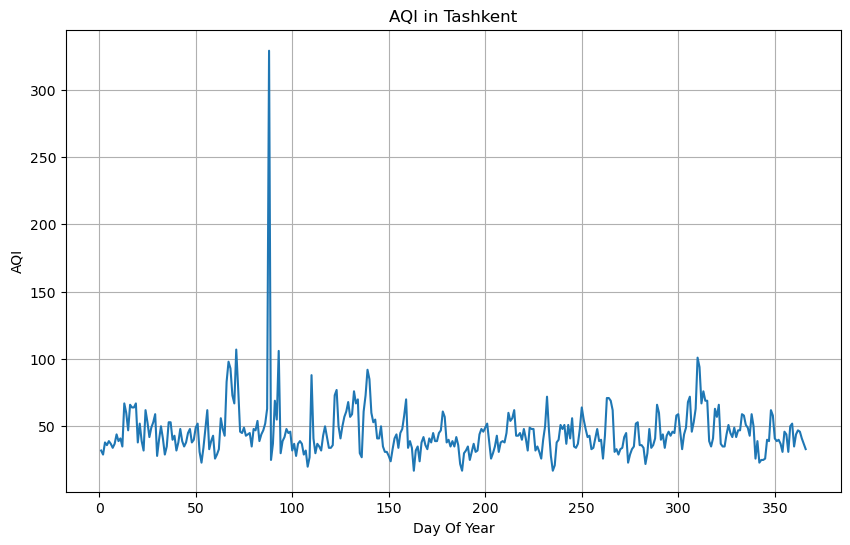

In [142]:
fig, ax = plt.subplots(figsize=(10, 6)) # figsize sets the width and height of the plot in inches
aqi_df_plot = aqi_df[aqi_df["date"].dt.year == 2024]
# Plotting the data:
# The most basic way: ax.plot(x_values, y_values)
ax.plot(aqi_df_plot["date"].dt.dayofyear, aqi_df_plot["pm25"])

# Adding labels and a title makes your plot understandable
ax.set_xlabel('Day Of Year')
ax.set_ylabel('AQI')
ax.set_title('AQI in Tashkent')

# Add a grid for better readability
ax.grid(True)

# --- 3. Display the plot ---
plt.show()

In [143]:
for_test = aqi_df[["date", "aqi"]].copy()

In [144]:
for_test.set_index('date', inplace=True)

In [145]:
for i in range(1, 8):
    for_test[f'aqi_lag_{i}'] = for_test['aqi'].shift(i)

In [146]:
for_test['aqi_rolling_mean_6'] = for_test['aqi'].rolling(window=7).mean()
for_test['aqi_rolling_std_6'] = for_test['aqi'].rolling(window=7).std()

In [147]:
Y = for_test['aqi']
X = for_test.drop(columns=['aqi'], axis=1)

In [148]:
combined_df = pd.concat([X, Y], axis=1)
cleaned_df = combined_df.dropna()
Y = cleaned_df['aqi']
X = cleaned_df.drop(columns=['aqi'], axis=1)

In [149]:
split_point = int(len(cleaned_df)*0.8)

X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

In [150]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3354, 9) (3354,)
(839, 9) (839,)


In [151]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05    # XGBoost handles NaNs by default, no special parameter needed
)

model.fit(X_train, Y_train,
          eval_set=[(X_test, Y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Make predictions on the test data
y_pred = model.predict(X_test)

# 2. Calculate the metrics
mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 5.81
Root Mean Squared Error (RMSE): 11.34
R-squared (R2): 0.64


In [153]:
import pickle

# Let's assume 'model' is your trained XGBoost model object

# 1. Define the filename for your model
filename = 'aqi_xgboost_model.pkl'

# 2. Open the file in write-binary ('wb') mode and save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully to {filename}")

Model saved successfully to aqi_xgboost_model.pkl
